## Imports and function definitions



In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: 


## Helper functions for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [30]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  print ("After DL of image. Returned from function:",filename)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=8,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("LiberationMono-Regular.ttf",
                              50)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Loading NN-Model into memory
Possible models:
* **FasterRCNN+InceptionResNet V2**: high accuracy, very slow
* **ssd+mobilenet V2**: small and fast.

In [42]:
#downloaded_image_path = r"C:\Users\Philipp Ding\Desktop\test1.jpg"

'''
#Used to download models from the web
list_models = ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
module_handle = list_models[0]
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
'''

with tf.Graph().as_default():
  detector = hub.Module(r"models/smallAndFast") #Model saved locally. If from web, have to use 'module_handle'
  image_string_placeholder = tf.placeholder(tf.string)
  decoded_image = tf.image.decode_jpeg(image_string_placeholder)
  # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
  # of size 1 and type tf.float32.
  decoded_image_float = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
  module_input = tf.expand_dims(decoded_image_float, 0)
  result = detector(module_input, as_dict=True)
  init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

  session = tf.Session()
  session.run(init_ops)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Loading picture into NN-Model
Image analysis took 
* 141.92 seconds with **InceptionResNet**.
* 0.5-0.8 seconds with **mobilenet**.

Output is an Numpy-array with 5 dimensions:
* detection_scores
* detection_boxes
* detection_class_entities 
* detection_class_labels 
* detection_class_names


Analysis took 0.74 seconds.
Found 100 objects.
Plotting took 0.95 seconds.


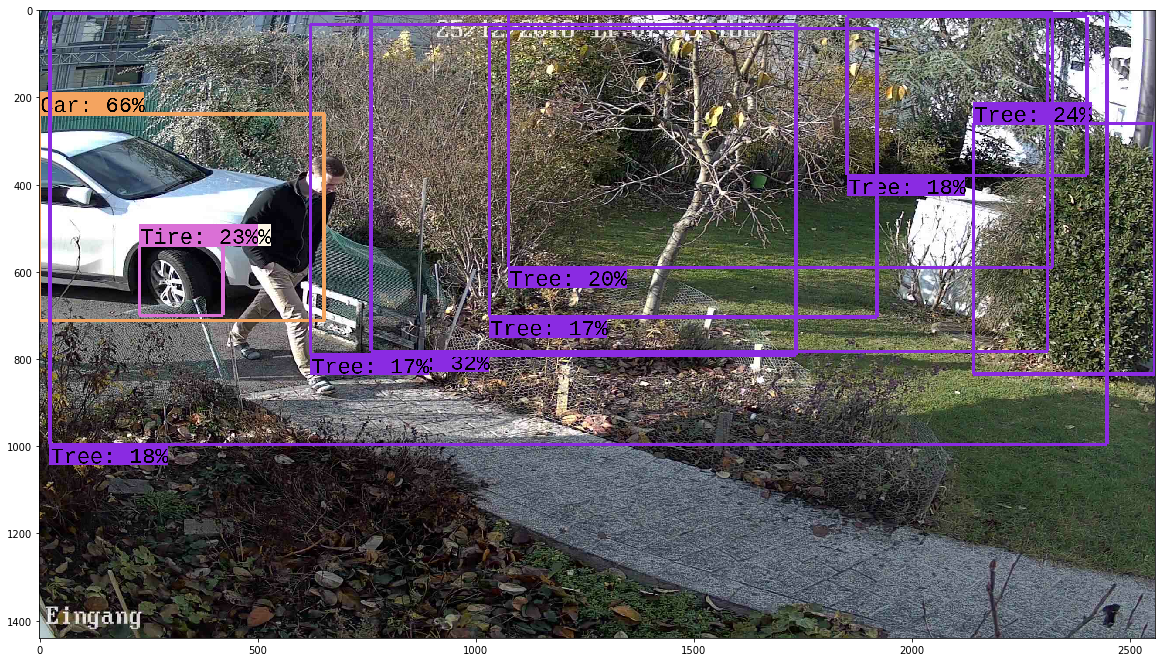

In [89]:
#Inputing image
image_path = [r"pictures\test0.jpg", r"pictures\test1.jpg", r"pictures\test2.jpg", r"pictures\test3.jpg", 
             r"pictures\test4.jpg", r"pictures\test5.jpg", r"pictures\test6.jpg", r"pictures\test7.jpg"]
image_path = image_path[2]

#To load in pictures saved locally
with tf.gfile.Open(image_path, "rb") as binfile:
    image_string = binfile.read()

#To load in the picture directly from the webcam
import requests
r = requests.get("http://192.168.1.4/cgi-bin/api.cgi?cmd=Snap&channel=0&rs=wdzukkmavractzla&user=pythonprogram&password=V9jyyj65QfMUNL5Fu0uq")
#image_string = r.content   

#start timer for analysis
inference_start_time = time.clock()

result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})

print("Analysis took %.2f seconds." % (time.clock()-inference_start_time))
print("Found %d objects." % len(result_out["detection_scores"]))


#start timer for ploting
inference_start_time = time.clock()

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"], min_score=0.1)

display_image(image_with_boxes)

print("Plotting took %.2f seconds." % (time.clock()-inference_start_time))

## Analysis of Numpy-Output

Person is:
* detection class label: 69 
* detection class entities: b'Person
* detection class names: b'/m/01g317'

In [ ]:
print (result_out.keys(),"\n")

#for key in result_out.keys():
#    print (key, ": ", result_out[key][10:30])

print("Recognized objects:", result_out["detection_class_entities"][:50])

print ("\n\n")
value = 69
if value in result_out["detection_class_labels"]:
    print ("Person found")
else:
    print ("No person found")


### Draw boxes around people only

In [92]:
indices = np.where(result_out["detection_class_labels"]==69) # 69=b'Person'

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"][indices],
    result_out["detection_class_entities"][indices], 
    result_out["detection_scores"][indices]
    , min_score=0.1)

#display_image(image_with_boxes)

AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

### Saving image with boxes to jpeg

In [97]:
out_image = tf.image.encode_jpeg(image_with_boxes, quality=80)
with tf.Session():
    tf.write_file("saved_pictures/test.jpg", out_image).run()
        


### Check a series of images to determine if there is a person in it

In [11]:
image_path = [r"pictures\test0.jpg", r"pictures\test1.jpg", r"pictures\test2.jpg", r"pictures\test3.jpg", 
             r"pictures\test4.jpg", r"pictures\test5.jpg", r"pictures\test6.jpg", r"pictures\test7.jpg"]

for path in image_path:
    with tf.gfile.Open(path, "rb") as binfile:
        image_string = binfile.read()

    #start timer for analysis
    inference_start_time = time.clock()

    result_out, image_out = session.run(
          [result, decoded_image],
          feed_dict={image_string_placeholder: image_string})

    print("Analysis took %.2f seconds." % (time.clock()-inference_start_time))
    
    #check if person in picture
    value = 69
    if value in result_out["detection_class_labels"]:
        print ("Person found")
    else:
        print ("No person found")
    
    print ("\n")
    

Analysis took 0.73 seconds.
No person found


Analysis took 0.78 seconds.
Person found


Analysis took 1.12 seconds.
Person found


Analysis took 1.00 seconds.
Person found


Analysis took 0.75 seconds.
No person found


Analysis took 0.72 seconds.
No person found


Analysis took 0.84 seconds.
No person found


Analysis took 0.91 seconds.
No person found




### Saving to file and sending to telegram

In [1]:
import telegram
import datetime

def filename_current_time():
    currentDT = datetime.datetime.now()
    file_name = "{}-{}-{} " \
                "{}.{}.{}.jpg".format(currentDT.year, currentDT.month, currentDT.day,
                              currentDT.hour, currentDT.minute, currentDT.second)
    return file_name

bot = telegram.Bot("638559352:AAHJQU_I_kvNLQoRiH79f-rKYf6VBOwjz9U")
bot.send_photo(chat_id=435398227, photo=open("pictures/test1.jpg", 'rb'))

    